In [1]:
import os
import random
import skimage.data
import skimage.transform
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Allow image embeding in notebook
%matplotlib inline

In [2]:
# Test tensor flow

hello = tf.constant('Hello, TensorFlow!')
sess = tf.Session()
a = tf.constant(10)
b = tf.constant(32)
print(sess.run(a + b))

42


In [107]:
import math
import random

width = 160
height = 120

startingIndex = 3500
LastYaw = 0
# Import Labels
labels = []
fname = "./AccelerationData/accelClass.txt"
with open(fname) as f:
    content = f.readlines()
    for line in content:
        line = line.split(",")
        #print line
        MXValueString = (line[3].split(" "))[2]
        PitchValueString = (line[1].split(" "))[2]
        Pitch = float(PitchValueString)
        MXPitchFactor = math.sin(math.radians(Pitch))
        MX = float(MXValueString) + MXPitchFactor
        MX = MX * 200
        YawValueString = (line[2].split(" "))[2]
        Yaw = float(YawValueString)
        #print Yaw
        Yaw = float(YawValueString)
        YawDiff = (Yaw - LastYaw)*2
        #print YawDiff
        LastYaw = Yaw
        labels.append(abs(int(YawDiff+10)))
labels = labels[startingIndex:(len(labels)-30)]


images = []
imageDir = "./AccelerationData/Pictures"
#pictures = os.listdir(imageDir)
for i in range(startingIndex,len(labels)+startingIndex):
    picDir = imageDir + "/image" + str(i) + ".ppm"
    #print picDir
    images.append(skimage.data.imread(picDir))

train_images = []
train_labels = []
test_labels = [] 
test_images = []
for i in range(0,len(labels)):
    if(random.random() * 10.0 < 5):
        test_labels.append(labels[i])
        test_images.append(images[i])
    else:
        train_labels.append(labels[i])
        train_images.append(images[i])

labels = train_labels
images = train_images

print len(images)
print len(labels)
print sum(labels)*1.0/len(labels)

print len(test_labels)
print len(test_images)

print("Unique Labels: {0}\nTotal Images: {1}".format(len(set(labels)), len(images)))


1002
1002
9.59580838323
889
889
Unique Labels: 23
Total Images: 1002


In [108]:
# Resize images
images32 = [skimage.transform.resize(image, (height, width))
                for image in images]


In [125]:
labels_a = np.array(labels)
images_a = np.array(images32)
print("labels: ", labels_a.shape, "\nimages: ", images_a.shape)

('labels: ', (1002,), '\nimages: ', (1002, 120, 160, 3))


In [130]:
# Create a graph to hold the model.
graph = tf.Graph()

# Create model in the graph.
with graph.as_default():
    # Placeholders for inputs and labels.
    images_ph = tf.placeholder(tf.float32, [None, height, width, 3])
    labels_ph = tf.placeholder(tf.int32, [None])

    # Flatten input from: [None, height, width, channels]
    # To: [None, height * width * channels] == [None, 3072]
    images_flat = tf.contrib.layers.flatten(images_ph)

    # Fully connected layer. 
    # Generates logits of size [None, 62]
    logits = tf.contrib.layers.fully_connected(images_flat, 100, tf.sigmoid)

    # Convert logits to label indexes (int).
    # Shape [None], which is a 1D vector of length == batch_size.
    predicted_labels = tf.argmax(logits, 1)

    # Define the loss function. 
    # Cross-entropy is a good choice for classification.
    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits, labels_ph))

    # Create training op.
    train = tf.train.AdamOptimizer(learning_rate=0.00001).minimize(loss)

    # And, finally, an initialization op to execute before training.
    # TODO: rename to tf.global_variables_initializer() on TF 0.12.
    init = tf.global_variables_initializer()

print("images_flat: ", images_flat)
print("logits: ", logits)
print("loss: ", loss)
print("predicted_labels: ", predicted_labels)

('images_flat: ', <tf.Tensor 'Flatten/Reshape:0' shape=(?, 57600) dtype=float32>)
('logits: ', <tf.Tensor 'fully_connected/Sigmoid:0' shape=(?, 100) dtype=float32>)
('loss: ', <tf.Tensor 'Mean:0' shape=() dtype=float32>)
('predicted_labels: ', <tf.Tensor 'ArgMax:0' shape=(?,) dtype=int64>)


In [131]:
# Create a session to run the graph we created.
session = tf.Session(graph=graph)

# First step is always to initialize all variables. 
# We don't care about the return value, though. It's None.
_ = session.run([init])

In [132]:
for i in range(20):
    _, loss_value = session.run([train, loss], 
                                feed_dict={images_ph: images_a, labels_ph: labels_a})
    if i % 10 == 0:
        print("Loss: ", loss_value)

('Loss: ', 4.6172132)
('Loss: ', 4.2673664)


In [133]:
# Pick 10 random images
sample_indexes = random.sample(range(len(images32)), 100)
sample_images = [images32[i] for i in sample_indexes]
sample_labels = [labels[i] for i in sample_indexes]

# Run the "predicted_labels" op.
predicted = session.run([predicted_labels], 
                        feed_dict={images_ph: sample_images})[0]

error = 0.0
numIndexes = 0.0
for i in range(0,len(sample_indexes)):
    if(sample_labels[i] != 10):
        error = error + (sample_labels[i] - predicted[i]) * (sample_labels[i] - predicted[i])
        numIndexes = numIndexes + 1
        print sample_labels[i], predicted[i]
print error / numIndexes




9 12
8 9
7 9
9 5
12 9
11 12
8 12
8 9
11 12
5 9
8 9
8 9
7 9
13 12
7 9
9 12
8 9
9 12
9 9
9 12
9 12
8 9
11 12
9 9
9 5
8 12
8 5
12 9
15 9
9 5
7 9
7 12
11 5
15 9
16 9
11 9
11 9
11 9
9 5
7 5
8 5
11 12
9 9
12 9
9 12
8 9
9 9
11 5
9 9
9 12
9 9
15 9
11 9
9 9
7 11
11 5
11 9
11 5
9 5
9 9
9 9
6 12
8 12
4 9
9 5
9 12
11 12
11 12
8 9
9 9
9 9
9 12
10.3333333333


ValueError: num must be 1 <= num <= 10, not 11

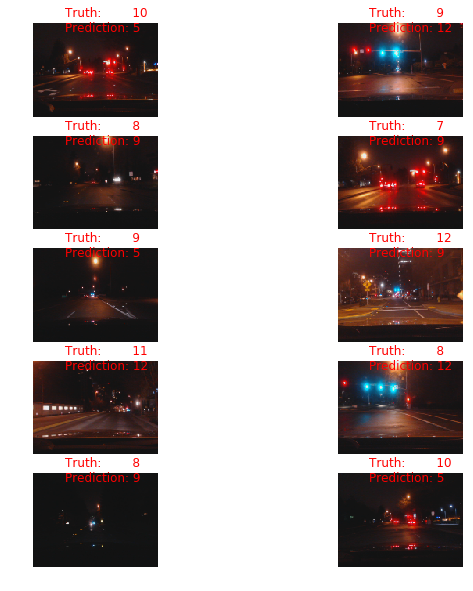

In [134]:
# Display the predictions and the ground truth visually.
fig = plt.figure(figsize=(10, 10))
for i in range(len(sample_images)):
    truth = sample_labels[i]
    prediction = predicted[i]
    plt.subplot(5, 2,1+i)
    plt.axis('off')
    color='green' if truth == prediction else 'red'
    plt.text(40, 10, "Truth:        {0}\nPrediction: {1}".format(truth, prediction), 
             fontsize=12, color=color)
    plt.imshow(sample_images[i])


In [135]:
# Transform the images, just like we did with the training set.
test_images32 = [skimage.transform.resize(image, (height, width))
                 for image in test_images]

In [137]:
# Run predictions against the full test set.
predicted = session.run([predicted_labels], 
                        feed_dict={images_ph: test_images32})[0]

error = 0.0
numIndexes = 0.0
matchCount = 0
for i in range(0,len(test_labels)):
    if(test_labels[i] != 10):
        error = error + (test_labels[i] - predicted[i]) * (test_labels[i] - predicted[i])
        numIndexes = numIndexes + 1
        if(test_labels[i] == predicted[i]):
            matchCount = matchCount + 1
        #print test_labels[i], predicted[i]
print error / numIndexes
print "Match Accuracy : " + str(match_count / numIndexes)


12.8573667712
Match Accuracy : 0.363636363636
